## Importing Libraries & Mount Google Drive

In [ ]:
# various snippets of code in this block were autofilled in using AI

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Run on GPU

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


## A. Load a Dataset

Load in the already formatted tensors.

In [ ]:
# various snippets of code in this block were autofilled in using AI

X_train = torch.load('/content/drive/MyDrive/X_train_tensor_d1.pt').to(device)
X_test = torch.load('/content/drive/MyDrive/X_test_tensor_d1.pt').to(device)
y_train = torch.load('/content/drive/MyDrive/y_train_tensor_d1.pt').to(device)
y_test = torch.load('/content/drive/MyDrive/y_test_tensor_d1.pt').to(device)

<ipython-input-3-628afe5a4b7b>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X_train = torch.load('/content/drive/MyDrive/X_train_tensor_d1.pt').to(device)
<ipython-input

## Create a Dataloaded for batching

In [ ]:
batch_size = 256
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

## B. Create a shallow neural network

In [ ]:
# various snippets of code in this block were autofilled in using AI

class ShallowNN(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, embedding_dim = 128):
    super(ShallowNN, self).__init__()
    self.fc1 = nn.Linear(input_dim * embedding_dim, hidden_dim)
    self.fc2 = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
    x = x.view(x.size(0), -1) # flatten
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

## B. Train the network

Create the function

In [ ]:
# various snippets of code in this block were autofilled in using AI

def train_model(model, train_loader, criterion, optimizer, epochs = 10):
  model.train()
  for epoch in range(epochs):
    total_loss = 0
    for X_batch, y_batch in train_loader:
      X_batch, y_batch = X_batch.to(device), y_batch.to(device)
      optimizer.zero_grad()
      outputs = model(X_batch)
      loss = criterion(outputs, y_batch)
      loss.backward()
      optimizer.step()
      total_loss += loss.item()
    print(f'Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader): .4f}')

# D. Test the network

Create the function

In [ ]:
# various snippets of code in this block were autofilled in using AI

def evaluate_model(model, test_loader, criterion):
  model.eval()
  test_loss = 0
  correct = 0
  total = 0
  with torch.no_grad():
    for X_batch, y_batch in test_loader:
      X_batch, y_batch = X_batch.to(device), y_batch.to(device)
      outputs = model(X_batch)
      loss = criterion(outputs, y_batch)
      test_loss += loss.item()
      predicted = torch.argmax(outputs, dim=1)
      correct += (predicted == torch.argmax(y_batch, dim=1)).sum().item()
      total += y_batch.size(0)
  accuracy = correct / total
  return test_loss / len(test_loader), accuracy

## E. Hyperparameter Experimentation

Training loop

In [ ]:
# various snippets of code in this block were autofilled in using AI

hidden_dims = [2,8,32,128]
test_losses = []
test_accuracies = []

input_dim = X_train.shape[1] # Input size from SMILES embeddings
output_dim = y_train.shape[1] # Number of drug classes

for hidden_dim in hidden_dims:
  print(f'Training model with hidden dimension {hidden_dim} num of neurons...')
  model = ShallowNN(input_dim, hidden_dim, output_dim).to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  train_model(model, train_loader, criterion, optimizer, epochs = 5)
  test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)

  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)
  print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Training model with hidden dimension 2 num of neurons...
Epoch 1/5, Loss:  1.6549
Epoch 2/5, Loss:  1.6336
Epoch 3/5, Loss:  1.6258
Epoch 4/5, Loss:  1.6178
Epoch 5/5, Loss:  1.6114
Test Loss: 1.6063, Test Accuracy: 0.1644
Training model with hidden dimension 8 num of neurons...
Epoch 1/5, Loss:  4.0515
Epoch 2/5, Loss:  1.5368
Epoch 3/5, Loss:  1.4985
Epoch 4/5, Loss:  1.4633
Epoch 5/5, Loss:  1.4337
Test Loss: 1.5163, Test Accuracy: 0.3259
Training model with hidden dimension 32 num of neurons...
Epoch 1/5, Loss:  3.9402
Epoch 2/5, Loss:  1.6278
Epoch 3/5, Loss:  1.6186
Epoch 4/5, Loss:  1.6083
Epoch 5/5, Loss:  1.5930
Test Loss: 1.6019, Test Accuracy: 0.1939
Training model with hidden dimension 128 num of neurons...
Epoch 1/5, Loss:  5.6596
Epoch 2/5, Loss:  1.6066
Epoch 3/5, Loss:  1.5687
Epoch 4/5, Loss:  1.5266
Epoch 5/5, Loss:  1.4900
Test Loss: 1.4887, Test Accuracy: 0.3345


## F. Plot results

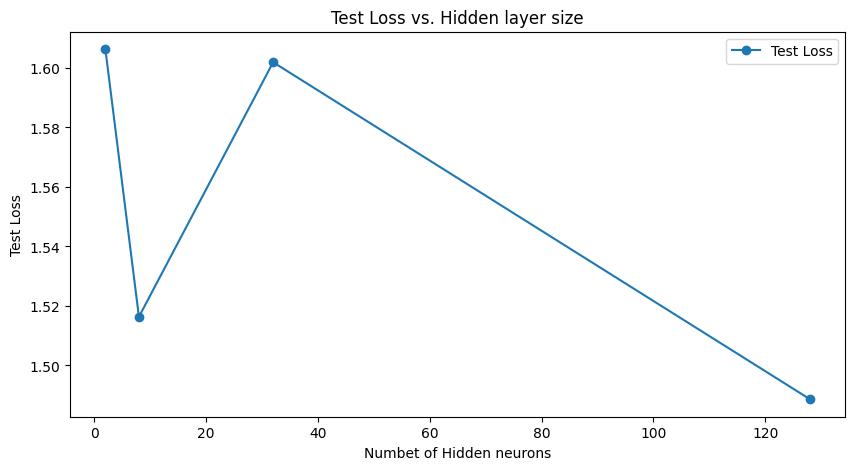

In [ ]:
# various snippets of code in this block were autofilled in using AI

plt.figure(figsize=(10, 5))
plt.plot(hidden_dims, test_losses, marker='o', linestyle='-', label='Test Loss')
plt.xlabel('Numbet of Hidden neurons')
plt.ylabel('Test Loss')
plt.title('Test Loss vs. Hidden layer size')
plt.legend()
plt.show()

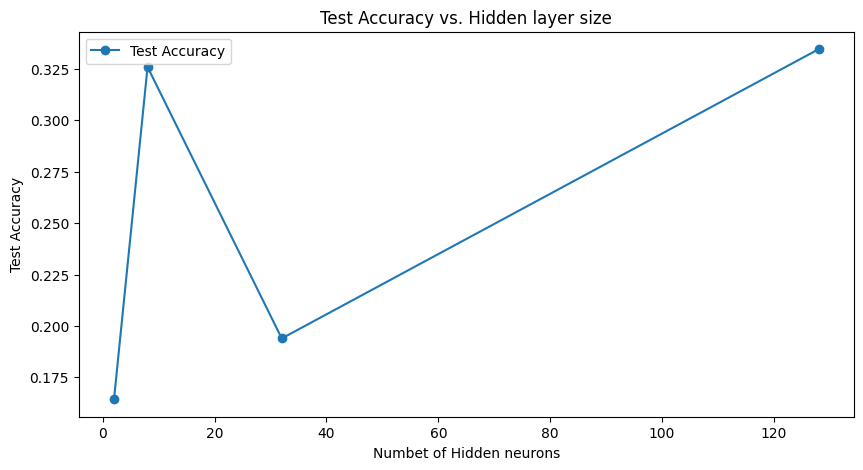

In [ ]:
# various snippets of code in this block were autofilled in using AI

plt.figure(figsize=(10, 5))
plt.plot(hidden_dims, test_accuracies, marker='o', linestyle='-', label='Test Accuracy')
plt.xlabel('Numbet of Hidden neurons')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. Hidden layer size')
plt.legend()
plt.show()